In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from PIL import Image
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [2]:
from keras.layers import Dense,Input,Activation,BatchNormalization,Reshape,Flatten
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import SGD
from keras.datasets import mnist

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def generator_model(): #生成器
    #The first dense layer takes a vector of 100 dimensions as input and 
    #it produces 1,024 dimensions with the activation function tanh as the output
    model_in = Input((100,))
    model = Dense(1024,activation='tanh')(model_in)
    
    #The next dense layer produces data of 128 x 7 x 7 
    #in the output using batch normalization 
    model = Dense(128*7*7)(model)
    model = BatchNormalization()(model)
    model = Activation('tanh')(model)
    
    #produces data of  7 x 7 x 128 (128 channels, 7 width, and 7 height)
    model = Reshape((7,7,128))(model)
    #produces a repetition of each one into a 2 x 2 square
    model = UpSampling2D(size=(2,2))(model)
    model = Conv2D(64,kernel_size=(5,5),activation='tanh',padding='same')(model)
    
    model = UpSampling2D(size=(2,2))(model)
    model = Conv2D(1,kernel_size=(5,5),activation='tanh',padding='same')(model)
    
    model = Model(inputs=model_in,outputs=model)
    
    return model

In [4]:
def discriminator_model(): #对抗器
    #  MNIST image with the shape (28, 28, 1)
    model_in = Input((28,28,1))
    
    # 64 filters of size 5 x 5 with tanh as the activation function
    model = Conv2D(64,kernel_size=(5,5),padding='same',activation='tanh')(model_in)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Conv2D(128,kernel_size=(5,5),activation='tanh')(model)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Flatten()(model)
    model = Dense(1024,activation='tanh')(model)
    model = Dense(1,activation='sigmoid')(model)
    
    model = Model(inputs=model_in,outputs=model)
    
    return model

In [5]:
def generator_containing_discriminator(g, d): # 将对抗器与生成器结合到一起，
    model = Sequential()
    model.add(g)
    d.trainable = False # 对抗器的layers为不可训练状态
    model.add(d)
    return model

def combine_images(generated_images): # 将生成的图片结合到一起
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = img[:, :, 0]
    return image

In [8]:
def train(BATCH_SIZE = 128):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    
    d = discriminator_model()
    g = generator_model()
    
    d_on_g = generator_containing_discriminator(g, d)
    
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    
    for epoch in range(100):
        print('Epoch is', epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save("outputs/"+str(epoch)+"_"+str(index)+".png")
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = d.train_on_batch(X, y)
#             print("batch %d d_loss : %f" % (index, d_loss))
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
#             print("batch %d g_loss : %f" % (index, g_loss))
            if index % 10 == 9:
                g.save_weights('generator', True)
                d.save_weights('discriminator', True)

In [10]:
train()

Epoch is 0
Number of batches 468
Epoch is 1
Number of batches 468
Epoch is 2
Number of batches 468
Epoch is 3
Number of batches 468
Epoch is 4
Number of batches 468
Epoch is 5
Number of batches 468
Epoch is 6
Number of batches 468
Epoch is 7
Number of batches 468
Epoch is 8
Number of batches 468
Epoch is 9
Number of batches 468
Epoch is 10
Number of batches 468
Epoch is 11
Number of batches 468
Epoch is 12
Number of batches 468
Epoch is 13
Number of batches 468
Epoch is 14
Number of batches 468
Epoch is 15
Number of batches 468
Epoch is 16
Number of batches 468
Epoch is 17
Number of batches 468
Epoch is 18
Number of batches 468
Epoch is 19
Number of batches 468
Epoch is 20
Number of batches 468
Epoch is 21
Number of batches 468
Epoch is 22
Number of batches 468
Epoch is 23
Number of batches 468
Epoch is 24
Number of batches 468
Epoch is 25
Number of batches 468
Epoch is 26
Number of batches 468
Epoch is 27
Number of batches 468
Epoch is 28
Number of batches 468
Epoch is 29
Number of ba

In [17]:
def generate(BATCH_SIZE=128, nice=False):
    g = generator_model()
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g.load_weights('generator')
    if nice:
        d = discriminator_model()
        d.compile(loss='binary_crossentropy', optimizer="SGD")
        d.load_weights('discriminator')
        noise = np.random.uniform(-1, 1, (BATCH_SIZE*20, 100))
        generated_images = g.predict(noise, verbose=1)
        d_pret = d.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE,) + generated_images.shape[1:3], dtype=np.float32)
        nice_images = nice_images[:, :, :, None]
        for i in range(BATCH_SIZE):
            idx = int(pre_with_index[i][1])
            nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]
        image = combine_images(nice_images)
    else:
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        generated_images = g.predict(noise, verbose=1)
        image = combine_images(generated_images)
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save("generated_image.png")

In [18]:
generate(nice=True)

2560/2560 [==============================] - 0s 102us/step


In [ ]:
!ls

In [ ]:
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


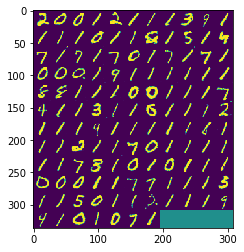

In [19]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('generated_image.png')
imgplot = plt.imshow(img)
plt.show()